tgb - 2/3/2020 - The goal of this notebook is to develop custom tensorflow layers to rescale inputs in order to facilitate generalization. We will consider three input rescalings in this notebook:  
1) From specific humidity to relative humidity  
2) From T to T-T_{NS}, NS=Near-surface  
3) From T to T-T_{MA}, MA=Approximate moist adiabat  

For Ankitesh:  
Step 1 = Reproduce the workflow with the batch normalization idea for both q/RH and check that (RH) one generalizes better. Is batch normalization a viable solution to creating a new norm file every time we try a new normalization.  
Step 2 = Add T-T{NS}. In [http://localhost:8885/edit/SPCAM/CBRAIN-CAM/cbrain/preprocessing/convert_dataset_20191113.py] similarly to ```TfromTs``` and ```TfromTMA```

# Imports

In [1]:
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.cam_constants import *
from cbrain.losses import *
from cbrain.utils import limit_mem
from cbrain.layers import *
from cbrain.data_generator import DataGenerator
import tensorflow as tf
import tensorflow.math as tfm
import tensorflow_probability as tfp
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as imag
import scipy.integrate as sin
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import pickle

TRAINDIR = '/local/Tom.Beucler/SPCAM_PHYS/'
DATADIR = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/'
PREFIX = '8col009_01_'
%cd /filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM

# Otherwise tensorflow will use ALL your GPU RAM for no reason
limit_mem()

/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages

/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog


W0219 16:50:20.208056 22699701032768 deprecation_wrapper.py:119] From /home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/utils.py:145: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0219 16:50:20.209043 22699701032768 deprecation_wrapper.py:119] From /home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/utils.py:148: The name tf.keras.backend.set_session is deprecated. Please use tf.compat.v1.keras.backend.set_session instead.

W0219 16:50:20.209650 22699701032768 deprecation_wrapper.py:119] From /home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/utils.py:148: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM


# Input Rescaling 1: Specific humidity to relative humidity

## Moist thermodynamics library

TODO = Clean up the library and put it in ```climate_invariant.py```

In [60]:
# Moist thermodynamics library adapted to tf
def eliq(T):
    a_liq = np.float32(np.array([-0.976195544e-15,-0.952447341e-13,\
                                 0.640689451e-10,\
                      0.206739458e-7,0.302950461e-5,0.264847430e-3,\
                      0.142986287e-1,0.443987641,6.11239921]));
    c_liq = np.float32(-80.0)
    T0 = np.float32(273.16)
    return np.float32(100.0)*tfm.polyval(a_liq,tfm.maximum(c_liq,T-T0))

def eice(T):
    a_ice = np.float32(np.array([0.252751365e-14,0.146898966e-11,0.385852041e-9,\
                      0.602588177e-7,0.615021634e-5,0.420895665e-3,\
                      0.188439774e-1,0.503160820,6.11147274]));
    c_ice = np.float32(np.array([273.15,185,-100,0.00763685,0.000151069,7.48215e-07]))
    T0 = np.float32(273.16)
    return tf.where(T>c_ice[0],eliq(T),\
                   tf.where(T<=c_ice[1],np.float32(100.0)*(c_ice[3]+tfm.maximum(c_ice[2],T-T0)*\
                   (c_ice[4]+tfm.maximum(c_ice[2],T-T0)*c_ice[5])),\
                           np.float32(100.0)*tfm.polyval(a_ice,T-T0)))

def esat(T):
    T0 = np.float32(273.16)
    T00 = np.float32(253.16)
    omtmp = (T-T00)/(T0-T00)
    omega = tfm.maximum(np.float32(0.0),tfm.minimum(np.float32(1.0),omtmp))

    return tf.where(T>T0,eliq(T),tf.where(T<T00,eice(T),(omega*eliq(T)+(1-omega)*eice(T))))

def qv(T,RH,P0,PS,hyam,hybm):
    
    R = np.float32(287.0)
    Rv = np.float32(461.0)
    p = P0 * hyam + PS[:, None] * hybm # Total pressure (Pa)
    
    T = tf.cast(T,tf.float32)
    RH = tf.cast(RH,tf.float32)
    p = tf.cast(p,tf.float32)
    
    return R*esat(T)*RH/(Rv*p)
    # DEBUG 1
    # return esat(T)
    
def RH(T,qv,P0,PS,hyam,hybm):
    R = np.float32(287.0)
    Rv = np.float32(461.0)
    p = P0 * hyam + PS[:, None] * hybm # Total pressure (Pa)
    
    T = tf.cast(T,tf.float32)
    qv = tf.cast(qv,tf.float32)
    p = tf.cast(p,tf.float32)
    
    return Rv*p*qv/(R*esat(T))

## Layers to convert from specific humidity to relative humidity

TODO: Add to ```climate-invariant.py```

In [61]:
class QV2RH(Layer):
    def __init__(self, inp_subQ, inp_divQ, inp_subRH, inp_divRH, hyam, hybm, **kwargs):
        """
        Call using ([input])
        Assumes
        prior: [QBP, 
        TBP, PS, SOLIN, SHFLX, LHFLX]
        Returns
        post(erior): [RHBP,
        TBP, PS, SOLIN, SHFLX, LHFLX]
        Arguments:
        inp_subQ = Normalization based on input with specific humidity (subtraction constant)
        inp_divQ = Normalization based on input with specific humidity (division constant)
        inp_subRH = Normalization based on input with relative humidity (subtraction constant)
        inp_divRH = Normalization based on input with relative humidity (division constant)
        hyam = Constant a for pressure based on mid-levels
        hybm = Constant b for pressure based on mid-levels
        """
        self.inp_subQ, self.inp_divQ, self.inp_subRH, self.inp_divRH, self.hyam, self.hybm = \
            np.array(inp_subQ), np.array(inp_divQ), np.array(inp_subRH), np.array(inp_divRH), \
        np.array(hyam), np.array(hybm)
        # Define variable indices here
        # Input
        self.QBP_idx = slice(0,30)
        self.TBP_idx = slice(30,60)
        self.PS_idx = 60
        self.SHFLX_idx = 62
        self.LHFLX_idx = 63

        super().__init__(**kwargs)

    def build(self, input_shape):
        super().build(input_shape)

    def get_config(self):
        config = {'inp_subQ': list(self.inp_subQ), 'inp_divQ': list(self.inp_divQ),
                  'inp_subRH': list(self.inp_subRH), 'inp_divRH': list(self.inp_divRH),
                  'hyam': list(self.hyam),'hybm': list(self.hybm)}
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
    def call(self, arrs):
        prior = arrs
        
        Tprior = prior[:,self.TBP_idx]*self.inp_divQ[self.TBP_idx]+self.inp_subQ[self.TBP_idx]
        qvprior = prior[:,self.QBP_idx]*self.inp_divQ[self.QBP_idx]+self.inp_subQ[self.QBP_idx]
        PSprior = prior[:,self.PS_idx]*self.inp_divQ[self.PS_idx]+self.inp_subQ[self.PS_idx]
        RHprior = (RH(Tprior,qvprior,P0,PSprior,self.hyam,self.hybm)-\
                    self.inp_subRH[self.QBP_idx])/self.inp_divRH[self.QBP_idx]
        
        post = tf.concat([tf.cast(RHprior,tf.float32),prior[:,30:]], axis=1)
        
        return post

    def compute_output_shape(self,input_shape):
        """Input shape + 1"""
        return (input_shape[0][0])

# Pre-process data for the experiment

## Specific humidity, norm file for (-4K)

Here is the configuration file ```CI_SP_M4K_NORM.yml```:
```
# Climate-invariant - Specific humidity - Minus 4K - Norm
vars : [QBP, TBP, PS, SOLIN, SHFLX, LHFLX, PHQ, TPHYSTND, FSNT, FSNS, FLNT, FLNS]

in_dir : /project/meteo/w2w/A6/S.Rasp/SP-CAM/sp8fbp_minus4k
in_fns : sp8fbp_minus4k.cam2.h2.0001-01-0*-00000.nc

out_dir: /local/Tom.Beucler/SPCAM_PHYS/
out_fn: CI_SP_M4K_NORM_train.nc

val_in_fns: sp8fbp_minus4k.cam2.h2.0001-01-0*-00000.nc
val_out_fn: CI_SP_M4K_NORM_valid.nc

norm_fn: CI_SP_M4K_NORM_norm.nc
```

We pre-process it below:

In [6]:
!python preprocessing-11132019.py -c /home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/CI_SP_M4K_NORM.yml

/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages

## Specific humidity, training and validation for (-4K)

Here is the configuration file ```CI_SP_M4K.yml```:
```
# Climate-invariant - Specific humidity - Minus 4K - Training and validation
vars : [QBP, TBP, PS, SOLIN, SHFLX, LHFLX, PHQ, TPHYSTND, FSNT, FSNS, FLNT, FLNS]

in_dir : /project/meteo/w2w/A6/S.Rasp/SP-CAM/sp8fbp_minus4k
in_fns : sp8fbp_minus4k.cam2.h2.0001-*-0*-00000.nc

out_dir: /local/Tom.Beucler/SPCAM_PHYS/
out_fn: CI_SP_M4K_train.nc

val_in_fns: sp8fbp_minus4k.cam2.h2.0001-*-1*-00000.nc
val_out_fn: CI_SP_M4K_valid.nc
```

In [7]:
!python preprocessing-11132019.py -c /home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/CI_SP_M4K.yml

/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages

## Specific humidity, norm file for (+4K)

Here is the configuration file ```CI_SP_P4K_NORM.yml```:
```
# Climate-invariant - Specific humidity - Plus 4K - Norm
vars : [QBP, TBP, PS, SOLIN, SHFLX, LHFLX, PHQ, TPHYSTND, FSNT, FSNS, FLNT, FLNS]

in_dir : /project/meteo/w2w/A6/S.Rasp/SP-CAM/sp8fbp_4k
in_fns : sp8fbp_4k.cam2.h2.0001-01-0*-00000.nc

out_dir: /local/Tom.Beucler/SPCAM_PHYS/
out_fn: CI_SP_P4K_NORM_train.nc

val_in_fns: sp8fbp_4k.cam2.h2.0001-01-0*-00000.nc
val_out_fn: CI_SP_P4K_NORM_valid.nc

norm_fn: CI_SP_P4K_NORM_norm.nc
```

In [8]:
!python preprocessing-11132019.py -c /home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/CI_SP_P4K_NORM.yml

/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages

## Specific humidity, training and validation for (+4K)

Here is the configuration file ```CI_SP_P4K.yml ```:
```
# Climate-invariant - Specific humidity - Plus 4K - Training and validation
vars : [QBP, TBP, PS, SOLIN, SHFLX, LHFLX, PHQ, TPHYSTND, FSNT, FSNS, FLNT, FLNS]

in_dir : /project/meteo/w2w/A6/S.Rasp/SP-CAM/sp8fbp_4k
in_fns : sp8fbp_4k.cam2.h2.0001-*-0*-00000.nc

out_dir: /local/Tom.Beucler/SPCAM_PHYS/
out_fn: CI_SP_P4K_train.nc

val_in_fns: sp8fbp_4k.cam2.h2.0001-*-1*-00000.nc
val_out_fn: CI_SP_P4K_valid.nc
```

In [9]:
!python preprocessing-11132019.py -c /home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/CI_SP_P4K.yml

/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages

## Relative humidity, norm file for (-4K)

Here is the configuration file ```CI_RH_M4K_NORM.yml```:
```
# Climate-invariant - Relative humidity - Minus 4K - Norm
vars : [RH, TBP, PS, SOLIN, SHFLX, LHFLX, PHQ, TPHYSTND, FSNT, FSNS, FLNT, FLNS]

in_dir : /project/meteo/w2w/A6/S.Rasp/SP-CAM/sp8fbp_minus4k
in_fns : sp8fbp_minus4k.cam2.h2.0001-01-0*-00000.nc

out_dir: /local/Tom.Beucler/SPCAM_PHYS/
out_fn: CI_RH_M4K_NORM_train.nc

val_in_fns: sp8fbp_minus4k.cam2.h2.0001-01-0*-00000.nc
val_out_fn: CI_RH_M4K_NORM_valid.nc

norm_fn: CI_RH_M4K_NORM_norm.nc
```

TODO: Test batch normalization layers - Create norm file of mean 0 and range 1, need to add batch layers

In [10]:
!python preprocessing-11132019.py -c /home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/CI_RH_M4K_NORM.yml

/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages

# Build and train models on (-4K) with and without the first input rescaling

## Generator using specific humidity inputs at (-4K)

In [4]:
scale_dict = load_pickle('./nn_config/scale_dicts/009_Wm2_scaling.pkl')

In [5]:
in_vars = ['QBP','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']

In [6]:
TRAINFILE = 'CI_SP_M4K_train_shuffle.nc'
NORMFILE = 'CI_SP_M4K_NORM_norm.nc'
VALIDFILE = 'CI_SP_M4K_valid.nc'

In [7]:
train_gen = DataGenerator(
    data_fn = TRAINDIR+TRAINFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True
)

In [8]:
valid_gen = DataGenerator(
    data_fn = TRAINDIR+VALIDFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True
)

Check that shapes of generated samples are consistent

In [9]:
print(train_gen[50][0].shape)
print(train_gen[50][1].shape)
print(valid_gen[78][0].shape)
print(valid_gen[78][1].shape)

(1024, 64)
(1024, 64)
(1024, 64)
(1024, 64)


## Generator using relative humidity inputs

In [10]:
scale_dict_RH = load_pickle('./nn_config/scale_dicts/009_Wm2_scaling.pkl')

In [11]:
scale_dict_RH['RH'] = 0.01*L_S/G, # Arbitrary 0.1 factor as specific humidity is generally below 2%  

In [12]:
in_vars_RH = ['RH','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
out_vars_RH = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']

In [13]:
TRAINFILE_RH = 'CI_RH_M4K_NORM_train_shuffle.nc'
NORMFILE_RH = 'CI_RH_M4K_NORM_norm.nc'
VALIDFILE_RH = 'CI_RH_M4K_NORM_valid.nc'

In [14]:
train_gen_RH = DataGenerator(
    data_fn = TRAINDIR+TRAINFILE_RH,
    input_vars = in_vars_RH,
    output_vars = out_vars_RH,
    norm_fn = TRAINDIR+NORMFILE_RH,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict_RH,
    batch_size=1024,
    shuffle=True
)

Check that shapes of generated samples are consistent

In [15]:
print(train_gen_RH[50][0].shape)
print(train_gen_RH[50][1].shape)
print(train_gen_RH[78][0].shape)
print(train_gen_RH[78][1].shape)

(1024, 64)
(1024, 64)
(1024, 64)
(1024, 64)


## Build "brute-force" model

In [16]:
inp = Input(shape=(64,))
densout = Dense(128, activation='linear')(inp)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (6):
    densout = Dense(128, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
out = Dense(64, activation='linear')(densout)
Brute_force = tf.keras.models.Model(inp, out)

W0203 20:03:20.347390 23260197443392 deprecation.py:506] From /home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [17]:
Brute_force.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 128)               0     

## Build model converting specific humidity to relative humidity as inputs

In [15]:
inp = Input(shape=(64,))
inpRH = QV2RH(inp_subQ=train_gen.input_transform.sub, 
              inp_divQ=train_gen.input_transform.div, 
              inp_subRH=train_gen_RH.input_transform.sub, 
              inp_divRH=train_gen_RH.input_transform.div, 
              hyam=hyam, hybm=hybm)(inp)
densout = Dense(128, activation='linear')(inpRH)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (6):
    densout = Dense(128, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
out = Dense(64, activation='linear')(densout)
Input_RH = tf.keras.models.Model(inp, out)

W0208 05:58:29.021448 22733910370112 deprecation.py:323] From <ipython-input-2-d8b861a31dd8>:20: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0208 05:58:29.074743 22733910370112 deprecation.py:506] From /home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [16]:
Input_RH.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
q_v2rh (QV2RH)               (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512 

## Compile and train both models for Nep (e.g. 10) epochs

In [20]:
path_HDF5 = '/local/Tom.Beucler/SPCAM_PHYS/HDF5_DATA/'
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save_BF = ModelCheckpoint(path_HDF5+'CI01_BF.hdf5',save_best_only=True, monitor='val_loss', mode='min')
mcp_save_RH = ModelCheckpoint(path_HDF5+'CI01_RH.hdf5',save_best_only=True, monitor='val_loss', mode='min')

In [17]:
#Brute_force.compile(tf.keras.optimizers.Adam(), loss=mse)
Input_RH.compile(tf.keras.optimizers.Adam(), loss=mse)

In [22]:
Nep = 10
Brute_force.fit_generator(train_gen, epochs=Nep, validation_data=valid_gen,\
              callbacks=[earlyStopping, mcp_save_BF])

Epoch 1/10
41376/41376 [==============================] - 252s 6ms/step - loss: 422.2687 - val_loss: 379.7717
Epoch 2/10
41376/41376 [==============================] - 251s 6ms/step - loss: 373.4242 - val_loss: 366.8192
Epoch 3/10
41376/41376 [==============================] - 252s 6ms/step - loss: 364.0181 - val_loss: 357.2235
Epoch 4/10
41376/41376 [==============================] - 250s 6ms/step - loss: 358.9917 - val_loss: 355.3069
Epoch 5/10
41376/41376 [==============================] - 251s 6ms/step - loss: 355.9355 - val_loss: 356.3034
Epoch 6/10
41376/41376 [==============================] - 250s 6ms/step - loss: 353.8153 - val_loss: 351.0591
Epoch 7/10
41376/41376 [==============================] - 251s 6ms/step - loss: 352.0802 - val_loss: 357.2676
Epoch 8/10
41376/41376 [==============================] - 252s 6ms/step - loss: 350.7423 - val_loss: 350.0558
Epoch 9/10
41376/41376 [==============================] - 251s 6ms/step - loss: 349.6989 - val_loss: 348.0157
Epoch 10/1

In [23]:
Nep = 10
Input_RH.fit_generator(train_gen, epochs=Nep, validation_data=valid_gen,\
              callbacks=[earlyStopping, mcp_save_RH])

Epoch 1/10
41376/41376 [==============================] - 302s 7ms/step - loss: 613.4270 - val_loss: 569.8912
Epoch 2/10
41376/41376 [==============================] - 301s 7ms/step - loss: 548.4543 - val_loss: 539.9586
Epoch 3/10
41376/41376 [==============================] - 298s 7ms/step - loss: 532.8021 - val_loss: 531.1984
Epoch 4/10
41376/41376 [==============================] - 298s 7ms/step - loss: 524.3498 - val_loss: 520.8333
Epoch 5/10
41376/41376 [==============================] - 298s 7ms/step - loss: 518.5004 - val_loss: 524.0867
Epoch 6/10
41376/41376 [==============================] - 301s 7ms/step - loss: 513.9757 - val_loss: 526.8451
Epoch 7/10
41376/41376 [==============================] - 300s 7ms/step - loss: 510.1706 - val_loss: 514.2112
Epoch 8/10
41376/41376 [==============================] - 300s 7ms/step - loss: 506.7798 - val_loss: 513.0064
Epoch 9/10
41376/41376 [==============================] - 300s 7ms/step - loss: 504.3581 - val_loss: 513.6531
Epoch 10/1

## Rerun relative humidity model following the RH normalization problem that was fixed on Feb 7th

In [18]:
path_HDF5 = '/local/Tom.Beucler/SPCAM_PHYS/HDF5_DATA/'
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save_RH = ModelCheckpoint(path_HDF5+'CI02_RH.hdf5',save_best_only=True, monitor='val_loss', mode='min')

In [19]:
Nep = 10
Input_RH.fit_generator(train_gen, epochs=Nep, validation_data=valid_gen,\
              callbacks=[earlyStopping, mcp_save_RH])

Epoch 1/10
41376/41376 [==============================] - 316s 8ms/step - loss: 409.5002 - val_loss: 373.5825
Epoch 2/10
41376/41376 [==============================] - 315s 8ms/step - loss: 366.1374 - val_loss: 371.6924
Epoch 3/10
34534/41376 [========================>.....] - ETA: 30s - loss: 358.7669

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



41376/41376 [==============================] - 314s 8ms/step - loss: 358.4568 - val_loss: 358.0435
Epoch 4/10
34724/41376 [========================>.....] - ETA: 30s - loss: 354.3279

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



41376/41376 [==============================] - 315s 8ms/step - loss: 354.0201 - val_loss: 352.2883
Epoch 5/10
35315/41376 [========================>.....] - ETA: 27s - loss: 351.4992

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



41376/41376 [==============================] - 313s 8ms/step - loss: 351.2947 - val_loss: 352.0117
Epoch 6/10
41376/41376 [==============================] - 312s 8ms/step - loss: 349.2638 - val_loss: 351.1807
Epoch 7/10
41376/41376 [==============================] - 298s 7ms/step - loss: 347.7525 - val_loss: 345.2139
Epoch 8/10
41376/41376 [==============================] - 298s 7ms/step - loss: 346.4265 - val_loss: 350.2253
Epoch 9/10
41376/41376 [==============================] - 299s 7ms/step - loss: 345.2925 - val_loss: 344.0417
Epoch 10/10
41376/41376 [==============================] - 299s 7ms/step - loss: 344.3353 - val_loss: 343.0259


# Compare the models' abilities to generalize to (+4K)

## Define configuration files for post-processing the two neural networks

Note that the architecture of the NN in the configuration file is not used (if the configuration file was not used to train the network). We only use it for the convenience of building a model diagnostics object.

Here is the configuration file ```CI_SP_M4K_CONFIG.yml```:
```
# [Configuration file] Climate-invariant - Specific humidity - Minus 4K - Training and validation
exp_name: 000_example
data_dir: /local/Tom.Beucler/SPCAM_PHYS/
train_fn: CI_SP_M4K_train_shuffle.nc
valid_fn: CI_SP_M4K_valid.nc
norm_fn: CI_SP_M4K_NORM_norm.nc

inputs: [QBP,TBP,PS,SOLIN,SHFLX,LHFLX]
outputs: [PHQ,TPHYSTND,FSNT,FSNS,FLNT,FLNS]

input_sub: mean
input_div: maxrs
output_dict: /home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/nn_config/scale_dicts/009_Wm2_scaling.pkl

hidden_layers: [1, 1]
epochs: 1
conservation_layer: False
loss: mse
```

## Build model diagnostics objects

In [4]:
path_HDF5 = '/local/Tom.Beucler/SPCAM_PHYS/HDF5_DATA/' # Path to NN weights
config_file = 'CI_SP_M4K_CONFIG.yml' # Configuration file
data_file = ['CI_SP_M4K_valid.nc','CI_SP_P4K_valid.nc'] # Validation/test data sets
NNarray = ['CI01_BF.hdf5','CI01_RH.hdf5'] # NN to evaluate
NNname = ['Brute force','Input RH'] # Name of NNs for plotting
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer,
            'QV2RH':QV2RH,'eliq':eliq,'eice':eice,'esat':esat,'qv':qv,'RH':RH}

In [5]:
# Indices of different variables
PHQ_idx = slice(0,30)
TPHYSTND_idx = slice(30,60)

Build model diagnostics object for each NN and each validation/test dataset

In [39]:
NN = {}; md = {};
%cd $TRAINDIR/HDF5_DATA
for i,NNs in enumerate(NNarray):
    print('NN name is ',NNs)
    path = path_HDF5+NNs
    NN[NNs] = load_model(path,custom_objects=dict_lay)
    md[NNs] = {}
    for j,data in enumerate(data_file):
        print('data name is ',data)
        md[NNs][data[6:-3]] = ModelDiagnostics(NN[NNs],
                                                '/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/'+config_file,
                                                '/local/Tom.Beucler/SPCAM_PHYS/'+data)

/scratch-local/Tom.Beucler/SPCAM_PHYS/HDF5_DATA
NN name is  CI01_BF.hdf5
data name is  CI_SP_M4K_valid.nc
data name is  CI_SP_P4K_valid.nc
NN name is  CI01_RH.hdf5


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


data name is  CI_SP_M4K_valid.nc
data name is  CI_SP_P4K_valid.nc


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


Loop over timesteps of the validation/test datasets and concatenate the prediction/truth of the networks. Note that the truths are the same for different NNs because we use the same inputs & outputs.

In [55]:
lat_ind = np.arange(26,40)
iini = 1000 # Initial time to sample
iend = iini+47 # One day later

diagno = {} # Diagnostics structure
diagno['truth'] = {} # Diagnostics structure for the truth
for i,NNs in enumerate(NNarray):
    print('i=',i,'& NNs=',NNs,'         ')
    diagno[NNs] = {} # Diagnostics structure for each NN
    for j,data in enumerate(data_file):
        diagno[NNs][data[6:-3]] = {} # Diagnostics structure for each data file
        if i==0: diagno['truth'][data[6:-3]] = {}
        print('j=',j,'& data=',data,'         ',end='\r')
        for itime in tqdm(np.arange(iini,iend)):
            # Get input, prediction and truth from NN
            inp, p, truth = md[NNs][data[6:-3]].get_inp_pred_truth(itime)  # [lat, lon, var, lev]
            # Get convective heating and moistening for each NN
            if itime==iini:
                if i==0:
                    diagno['truth'][data[6:-3]]['PHQ'] = md[NNs][data[6:-3]].reshape_ngeo(truth[:,PHQ_idx])[lat_ind,:,:,np.newaxis]
                    diagno['truth'][data[6:-3]]['TPHYSTND'] = md[NNs][data[6:-3]].reshape_ngeo(truth[:,TPHYSTND_idx])[lat_ind,:,:,np.newaxis]
                diagno[NNs][data[6:-3]]['PHQ'] = md[NNs][data[6:-3]].reshape_ngeo(p[:,PHQ_idx])[lat_ind,:,:,np.newaxis]
                diagno[NNs][data[6:-3]]['TPHYSTND'] = md[NNs][data[6:-3]].reshape_ngeo(p[:,TPHYSTND_idx])[lat_ind,:,:,np.newaxis]
            else:
                for istr,field in enumerate(['PHQ','TPHYSTND']):
                    if field=='PHQ': ind_field = PHQ_idx
                    elif field=='TPHYSTND': ind_field = TPHYSTND_idx
                    diagno[NNs][data[6:-3]][field] = np.concatenate((diagno[NNs][data[6:-3]][field],
                                                         md[NNs][data[6:-3]].\
                                                         reshape_ngeo(p[:,ind_field])[lat_ind,:,:,np.newaxis]),
                                                        axis=3)
                    if i==0:
                        diagno['truth'][data[6:-3]][field] = np.concatenate((diagno['truth'][data[6:-3]][field],
                                                                 md[NNs][data[6:-3]].\
                                                                 reshape_ngeo(truth[:,ind_field])[lat_ind,:,:,np.newaxis]),
                                                                axis=3)

i= 0 & NNs= CI01_BF.hdf5          


i= 1 & NNs= CI01_RH.hdf5          


## Load coordinates

In [11]:
# Load coordinates (just pick any file from the climate model run)
coor = xr.open_dataset("/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/AndKua_aqua_SPCAM3.0_sp_fbp_f4.cam2.h1.0000-01-01-00000.nc",\
                    decode_times=False)
lat = coor.lat; lon = coor.lon; lev = coor.lev;
coor.close();

In [70]:
coor.lat[26:40] # A tropical latitude range that we can use for testing

<xarray.DataArray 'lat' (lat: 14)>
array([-15.348365, -12.557756,  -9.767146,  -6.976534,  -4.185921,  -1.395307,
         1.395307,   4.185921,   6.976534,   9.767146,  12.557756,  15.348365,
        18.138971,  20.929574])
Coordinates:
  * lat      (lat) float64 -15.35 -12.56 -9.767 -6.977 ... 15.35 18.14 20.93
Attributes:
    long_name:  latitude
    units:      degrees_north

In [74]:
coor.lat[13:20] # A mid-latitude range that we can use for testing

<xarray.DataArray 'lat' (lat: 7)>
array([-51.625734, -48.835241, -46.044727, -43.254195, -40.463648, -37.67309 ,
       -34.882521])
Coordinates:
  * lat      (lat) float64 -51.63 -48.84 -46.04 -43.25 -40.46 -37.67 -34.88
Attributes:
    long_name:  latitude
    units:      degrees_north

In [79]:
coor.lat[0:7] # A polar range that we can use for testing

<xarray.DataArray 'lat' (lat: 7)>
array([-87.863799, -85.096527, -82.312913, -79.525607, -76.7369  , -73.947515,
       -71.157752])
Coordinates:
  * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 -76.74 -73.95 -71.16
Attributes:
    long_name:  latitude
    units:      degrees_north

## Plots

In [59]:
# Plot characteristics
fz = 20
lw = 4
plt.rc('text', usetex=True)
plt.rc('font',size=fz)
#plt.rc('font',**{'family':'serif','serif':['Computer Modern Roman']}, size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

In [56]:
diagno['truth'].keys()

dict_keys(['M4K_valid', 'P4K_valid'])

Validation on the (-4K) dataset: Both network perform relatively well

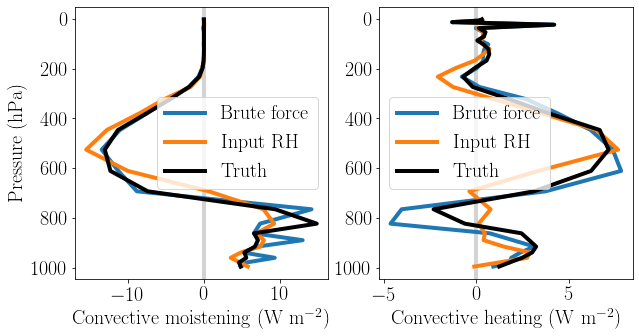

In [67]:
data = 'M4K_valid'

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray[0:2]):
    plt.plot(np.mean(diagno[NNs][data]['PHQ'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data]['PHQ'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend()
plt.xlabel('Convective moistening ($\mathrm{W\ m^{-2}}$)')
plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()
#plt.xlim((-20,20))

plt.subplot(1,2,2)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray[0:2]):
    plt.plot(np.mean(diagno[NNs][data]['TPHYSTND'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data]['TPHYSTND'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend()
plt.xlabel('Convective heating ($\mathrm{W\ m^{-2}}$)')
plt.gca().invert_yaxis()
#plt.xlim((-9,9))

On (+4K), the brute force is terrible and the RH is already an improvement

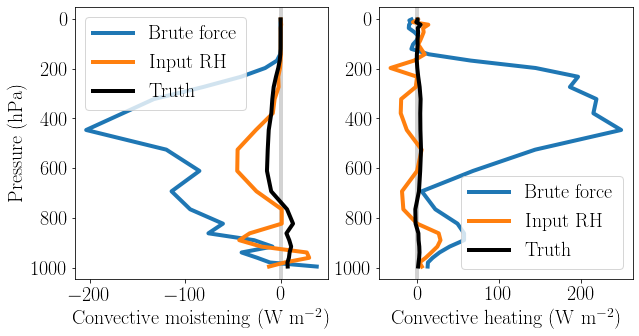

In [68]:
data = 'P4K_valid'

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray[0:2]):
    plt.plot(np.mean(diagno[NNs][data]['PHQ'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data]['PHQ'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend()
plt.xlabel('Convective moistening ($\mathrm{W\ m^{-2}}$)')
plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()
#plt.xlim((-20,20))

plt.subplot(1,2,2)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray[0:2]):
    plt.plot(np.mean(diagno[NNs][data]['TPHYSTND'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data]['TPHYSTND'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend()
plt.xlabel('Convective heating ($\mathrm{W\ m^{-2}}$)')
plt.gca().invert_yaxis()
#plt.xlim((-9,9))

Here's an example protocole we could systematically use to validate or infirm a new configuration:  
1) Always test on both datasets 'M4K_valid' and 'P4K_valid'  
2) Try a few different days to check consistency of results (e.g., ```iini=2000, iend = iini+47``` # One day later; ```iini=50, iend=iini+47```, etc.) I like to evaluate daily predictions because they take into account day+night without smoothing out the profiles.  
3) Always focus on the tropical latitude range (e.g., ```lat_ind = np.arange(26,40)``` because it's a good way to test the network's generalization abilities). But feel free to test "easier" generalization exercises, such as mid-latitude ranges ```lat_ind=np.arange(13,20)``` or polar ranges ```lat_ind=np.arange(0,7)```.

# Input Rescaling 2.1: Temperature difference from near-surface

## Add code to pre-process the temperature

Added to [https://github.com/tbeucler/CBRAIN-CAM/blob/master/cbrain/preprocessing/convert_dataset_20191113.py]

```
def compute_TfromNS(ds):
    return compute_bp(ds,'TBP')-compute_bp(ds,'TBP')[:,-1,:,:]
```

Further down:

```
        elif var == 'TfromNS':
            da = compute_TfromNS(ds)
```

Here's the configuration file ```CI_TNS_M4K_NORM.yml```:

```
# Climate-invariant - Temperature minus Near-surface temperature - Minus 4K - Norm
vars : [QBP, TfromNS, PS, SOLIN, SHFLX, LHFLX, PHQ, TPHYSTND, FSNT, FSNS, FLNT, FLNS]

in_dir : /project/meteo/w2w/A6/S.Rasp/SP-CAM/sp8fbp_minus4k
in_fns : sp8fbp_minus4k.cam2.h2.0001-01-0*-00000.nc

out_dir: /local/Tom.Beucler/SPCAM_PHYS/
out_fn: CI_TNS_M4K_NORM_train.nc

val_in_fns: sp8fbp_minus4k.cam2.h2.0001-01-0*-00000.nc
val_out_fn: CI_TNS_M4K_NORM_valid.nc

norm_fn: CI_TNS_M4K_NORM_norm.nc
```

In [84]:
%cd /filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM
!python preprocessing-11132019.py -c /home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/CI_TNS_M4K_NORM.yml

/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/t

In [85]:
# Check the new normalization file
norm_TNS = xr.open_dataset("/local/Tom.Beucler/SPCAM_PHYS/CI_TNS_M4K_NORM_norm.nc",\
                    decode_times=False)

In [93]:
norm_TNS['mean'][30:60] #mean(T-TNS)

<xarray.DataArray 'mean' (var_names: 30)>
array([-53.240288, -59.90063 , -75.48096 , -58.969616, -62.62715 , -68.27844 ,
       -73.11915 , -74.60736 , -74.58079 , -73.66806 , -71.46512 , -70.27829 ,
       -67.94189 , -65.71795 , -61.454643, -55.493885, -48.362823, -40.540913,
       -32.409367, -24.796879, -18.62835 , -14.084258, -11.036036,  -8.806993,
        -7.207234,  -5.607756,  -4.040127,  -2.567229,  -1.246233,   0.      ],
      dtype=float32)
Coordinates:
  * var_names  (var_names) object 'TfromNS' 'TfromNS' ... 'TfromNS' 'TfromNS'

In [94]:
norm_TNS['std'][30:60] #std(T-TNS)

<xarray.DataArray 'std' (var_names: 30)>
array([20.463589, 16.563189, 17.488655, 17.591537, 16.275633, 19.356598,
       23.816462, 25.734324, 24.633606, 22.44667 , 19.61215 , 16.284441,
       12.374237,  8.413588,  4.828762,  3.09024 ,  3.40921 ,  4.047138,
        4.258108,  3.951038,  3.36657 ,  2.682338,  2.07708 ,  1.702893,
        1.465724,  1.249364,  1.03815 ,  0.804251,  0.519043,  0.      ],
      dtype=float32)
Coordinates:
  * var_names  (var_names) object 'TfromNS' 'TfromNS' ... 'TfromNS' 'TfromNS'

## Code tensorflow layer to subtract the near-surface temperature from the temperature within the network

In [4]:
class T2TmTNS(Layer):
    def __init__(self, inp_subT, inp_divT, inp_subTNS, inp_divTNS, hyam, hybm, **kwargs):
        """
        From temperature to (temperature)-(near-surface temperature)
        Call using ([input])
        Assumes
        prior: [QBP, 
        TBP, 
        PS, SOLIN, SHFLX, LHFLX]
        Returns
        post(erior): [QBP,
        TfromNS, 
        PS, SOLIN, SHFLX, LHFLX]
        Arguments:
        inp_subT = Normalization based on input with temperature (subtraction constant)
        inp_divT = Normalization based on input with temperature (division constant)
        inp_subTNS = Normalization based on input with (temp - near-sur temp) (subtraction constant)
        inp_divTNS = Normalization based on input with (temp - near-sur temp) (division constant)
        hyam = Constant a for pressure based on mid-levels
        hybm = Constant b for pressure based on mid-levels
        """
        self.inp_subT, self.inp_divT, self.inp_subTNS, self.inp_divTNS, self.hyam, self.hybm = \
            np.array(inp_subT), np.array(inp_divT), np.array(inp_subTNS), np.array(inp_divTNS), \
        np.array(hyam), np.array(hybm)
        # Define variable indices here
        # Input
        self.QBP_idx = slice(0,30)
        self.TBP_idx = slice(30,60)
        self.PS_idx = 60
        self.SHFLX_idx = 62
        self.LHFLX_idx = 63

        super().__init__(**kwargs)

    def build(self, input_shape):
        super().build(input_shape)

    def get_config(self):
        config = {'inp_subT': list(self.inp_subT), 'inp_divT': list(self.inp_divT),
                  'inp_subTNS': list(self.inp_subTNS), 'inp_divTNS': list(self.inp_divTNS),
                  'hyam': list(self.hyam),'hybm': list(self.hybm)}
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
    def call(self, arrs):
        prior = arrs
        
        Tprior = prior[:,self.TBP_idx]*self.inp_divT[self.TBP_idx]+self.inp_subT[self.TBP_idx]
        
        Tile_dim = tf.constant([1,30],tf.int32)
        TNSprior = ((Tprior-tf.tile(tf.expand_dims(Tprior[:,-1],axis=1),Tile_dim))-\
                    self.inp_subTNS[self.TBP_idx])/\
        self.inp_divTNS[self.TBP_idx]
        
        post = tf.concat([prior[:,:30],tf.cast(TNSprior,tf.float32),prior[:,60:]], axis=1)
        
        return post

    def compute_output_shape(self,input_shape):
        """Input shape + 1"""
        return (input_shape[0][0])

## Build generators

### Generator using specific humidity inputs

In [5]:
scale_dict = load_pickle('./nn_config/scale_dicts/009_Wm2_scaling.pkl')

in_vars = ['QBP','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']


TRAINFILE = 'CI_SP_M4K_train_shuffle.nc'
NORMFILE = 'CI_SP_M4K_NORM_norm.nc'
VALIDFILE = 'CI_SP_M4K_valid.nc'


train_gen = DataGenerator(
    data_fn = TRAINDIR+TRAINFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True
)

valid_gen = DataGenerator(
    data_fn = TRAINDIR+VALIDFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True
)

Check consistency of generated samples

In [6]:
print(train_gen[50][0].shape)
print(train_gen[50][1].shape)
print(valid_gen[78][0].shape)
print(valid_gen[78][1].shape)

(1024, 64)
(1024, 64)
(1024, 64)
(1024, 64)


### Generator using (T-T_{near-surface}) inputs

In [7]:
in_vars = ['QBP','TfromNS','PS', 'SOLIN', 'SHFLX', 'LHFLX']
out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']

In [8]:
TRAINFILE_TNS = 'CI_TNS_M4K_NORM_train_shuffle.nc'
NORMFILE_TNS = 'CI_TNS_M4K_NORM_norm.nc'
VALIDFILE_TNS = 'CI_TNS_M4K_NORM_valid.nc'

In [9]:
train_gen_TNS = DataGenerator(
    data_fn = TRAINDIR+TRAINFILE_TNS,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE_TNS,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True
)

In [10]:
print(train_gen_TNS[50][0].shape)
print(train_gen_TNS[50][1].shape)
print(train_gen_TNS[78][0].shape)
print(train_gen_TNS[78][1].shape)

(1024, 64)
(1024, 64)
(1024, 64)
(1024, 64)


### Generator using RH inputs

In [11]:
scale_dict_RH = load_pickle('./nn_config/scale_dicts/009_Wm2_scaling.pkl')

scale_dict_RH['RH'] = 0.01*L_S/G, # Arbitrary 0.1 factor as specific humidity is generally below 2%

in_vars_RH = ['RH','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
out_vars_RH = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']

TRAINFILE_RH = 'CI_RH_M4K_NORM_train_shuffle.nc'
NORMFILE_RH = 'CI_RH_M4K_NORM_norm.nc'
VALIDFILE_RH = 'CI_RH_M4K_NORM_valid.nc'

train_gen_RH = DataGenerator(
    data_fn = TRAINDIR+TRAINFILE_RH,
    input_vars = in_vars_RH,
    output_vars = out_vars_RH,
    norm_fn = TRAINDIR+NORMFILE_RH,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict_RH,
    batch_size=1024,
    shuffle=True
)

In [12]:
print(train_gen_RH[50][0].shape)
print(train_gen_RH[50][1].shape)
print(train_gen_RH[78][0].shape)
print(train_gen_RH[78][1].shape)

(1024, 64)
(1024, 64)
(1024, 64)
(1024, 64)


## Build model converting temperature to (temperature-temperature_{NS}) as inputs

### Replace T with T-Tns

In [23]:
inp = Input(shape=(64,))
inpTNS = T2TmTNS(inp_subT=train_gen.input_transform.sub, 
              inp_divT=train_gen.input_transform.div, 
              inp_subTNS=train_gen_TNS.input_transform.sub, 
              inp_divTNS=train_gen_TNS.input_transform.div, 
              hyam=hyam, hybm=hybm)(inp)
densout = Dense(128, activation='linear')(inpTNS)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (6):
    densout = Dense(128, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
out = Dense(64, activation='linear')(densout)
Input_TNS = tf.keras.models.Model(inp, out)

In [24]:
Input_TNS.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
t2_tm_tns_3 (T2TmTNS)        (None, 64)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               8320      
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               16512     
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               1651

### Replace both T and q

In [25]:
inp2 = Input(shape=(64,))
inpRH = QV2RH(inp_subQ=train_gen.input_transform.sub, 
              inp_divQ=train_gen.input_transform.div, 
              inp_subRH=train_gen_RH.input_transform.sub, 
              inp_divRH=train_gen_RH.input_transform.div, 
              hyam=hyam, hybm=hybm)(inp2)
inpTNS = T2TmTNS(inp_subT=train_gen.input_transform.sub, 
              inp_divT=train_gen.input_transform.div, 
              inp_subTNS=train_gen_TNS.input_transform.sub, 
              inp_divTNS=train_gen_TNS.input_transform.div, 
              hyam=hyam, hybm=hybm)(inpRH)
densout = Dense(128, activation='linear')(inpTNS)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (6):
    densout = Dense(128, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
out2 = Dense(64, activation='linear')(densout)
Input_RH_TNS = tf.keras.models.Model(inp2, out2)

In [26]:
Input_RH_TNS.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
q_v2rh_1 (QV2RH)             (None, 64)                0         
_________________________________________________________________
t2_tm_tns_4 (T2TmTNS)        (None, 64)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 128)               8320      
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 128)               16512     
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 128)               0   

## Compile and train both models

In [27]:
path_HDF5 = '/local/Tom.Beucler/SPCAM_PHYS/HDF5_DATA/'
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save_TNS = ModelCheckpoint(path_HDF5+'CI01_TNS.hdf5',save_best_only=True, monitor='val_loss', mode='min')
mcp_save_RH_TNS = ModelCheckpoint(path_HDF5+'CI01_RH_TNS.hdf5',save_best_only=True, monitor='val_loss', mode='min')

In [28]:
Input_TNS.compile(tf.keras.optimizers.Adam(), loss=mse)
Input_RH_TNS.compile(tf.keras.optimizers.Adam(), loss=mse)

In [29]:
Nep = 10
Input_TNS.fit_generator(train_gen, epochs=Nep, validation_data=valid_gen,\
              callbacks=[earlyStopping, mcp_save_TNS])

Epoch 1/10
41376/41376 [==============================] - 269s 7ms/step - loss: 425.5686 - val_loss: 385.9283
Epoch 2/10
41376/41376 [==============================] - 268s 6ms/step - loss: 376.6831 - val_loss: 372.9419
Epoch 3/10
41376/41376 [==============================] - 267s 6ms/step - loss: 367.7207 - val_loss: 364.6639
Epoch 4/10
41376/41376 [==============================] - 269s 6ms/step - loss: 362.5334 - val_loss: 367.3149
Epoch 5/10
41376/41376 [==============================] - 268s 6ms/step - loss: 359.4836 - val_loss: 357.7273
Epoch 6/10
41376/41376 [==============================] - 269s 7ms/step - loss: 357.2794 - val_loss: 355.6747
Epoch 7/10
41376/41376 [==============================] - 268s 6ms/step - loss: 355.5087 - val_loss: 353.6861
Epoch 8/10
41376/41376 [==============================] - 268s 6ms/step - loss: 354.0059 - val_loss: 355.3643
Epoch 9/10
41376/41376 [==============================] - 267s 6ms/step - loss: 352.7731 - val_loss: 354.9357
Epoch 10/1

In [30]:
Nep = 10
Input_RH_TNS.fit_generator(train_gen, epochs=Nep, validation_data=valid_gen,\
              callbacks=[earlyStopping, mcp_save_RH_TNS])

Epoch 1/10
41376/41376 [==============================] - 299s 7ms/step - loss: 397.0108 - val_loss: 361.0776
Epoch 2/10
41376/41376 [==============================] - 298s 7ms/step - loss: 356.2018 - val_loss: 352.0984
Epoch 3/10
41376/41376 [==============================] - 298s 7ms/step - loss: 349.4141 - val_loss: 349.0415
Epoch 4/10
41376/41376 [==============================] - 298s 7ms/step - loss: 345.9084 - val_loss: 344.5695
Epoch 5/10
41376/41376 [==============================] - 299s 7ms/step - loss: 343.6950 - val_loss: 344.7899
Epoch 6/10
41376/41376 [==============================] - 298s 7ms/step - loss: 342.1013 - val_loss: 340.5274
Epoch 7/10
41376/41376 [==============================] - 303s 7ms/step - loss: 340.8929 - val_loss: 339.9531
Epoch 8/10
41376/41376 [==============================] - 297s 7ms/step - loss: 339.8859 - val_loss: 339.4483
Epoch 9/10
41376/41376 [==============================] - 307s 7ms/step - loss: 338.9992 - val_loss: 340.3349
Epoch 10/1

# Compare the models' abilities to generalize including the temperature scaling

## Build model diagnostics

In [21]:
path_HDF5 = '/local/Tom.Beucler/SPCAM_PHYS/HDF5_DATA/' # Path to NN weights
config_file = 'CI_SP_M4K_CONFIG.yml' # Configuration file
data_file = ['CI_SP_M4K_valid.nc','CI_SP_P4K_valid.nc'] # Validation/test data sets
NNarray = ['CI01_BF.hdf5','CI02_RH.hdf5','CI01_TNS.hdf5','CI01_RH_TNS.hdf5'] # NN to evaluate
NNname = ['Brute force','Input RH','Input TNS','Input RH TNS'] # Name of NNs for plotting
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer,
            'QV2RH':QV2RH,'T2TmTNS':T2TmTNS,'eliq':eliq,'eice':eice,'esat':esat,'qv':qv,'RH':RH}

In [6]:
# Indices of different variables
PHQ_idx = slice(0,30)
TPHYSTND_idx = slice(30,60)

In [8]:
NN = {}; md = {};
%cd $TRAINDIR/HDF5_DATA
for i,NNs in enumerate(NNarray):
    print('NN name is ',NNs)
    path = path_HDF5+NNs
    NN[NNs] = load_model(path,custom_objects=dict_lay)
    md[NNs] = {}
    for j,data in enumerate(data_file):
        print('data name is ',data)
        md[NNs][data[6:-3]] = ModelDiagnostics(NN[NNs],
                                                '/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/'+config_file,
                                                '/local/Tom.Beucler/SPCAM_PHYS/'+data)

/scratch-local/Tom.Beucler/SPCAM_PHYS/HDF5_DATA
NN name is  CI01_BF.hdf5
data name is  CI_SP_M4K_valid.nc
data name is  CI_SP_P4K_valid.nc
NN name is  CI02_RH.hdf5


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


data name is  CI_SP_M4K_valid.nc
data name is  CI_SP_P4K_valid.nc
NN name is  CI01_TNS.hdf5


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


data name is  CI_SP_M4K_valid.nc
data name is  CI_SP_P4K_valid.nc
NN name is  CI01_RH_TNS.hdf5


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


data name is  CI_SP_M4K_valid.nc
data name is  CI_SP_P4K_valid.nc


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


## Concatenate samples processed through different NNs

In [44]:
lat_ind = np.arange(0,7)
iini = 500 # Initial time to sample
iend = iini+47 # One day later

diagno = {} # Diagnostics structure
diagno['truth'] = {} # Diagnostics structure for the truth
for i,NNs in enumerate(NNarray):
    print('i=',i,'& NNs=',NNs,'         ')
    diagno[NNs] = {} # Diagnostics structure for each NN
    for j,data in enumerate(data_file):
        diagno[NNs][data[6:-3]] = {} # Diagnostics structure for each data file
        if i==0: diagno['truth'][data[6:-3]] = {}
        print('j=',j,'& data=',data,'         ',end='\r')
        for itime in tqdm(np.arange(iini,iend)):
            # Get input, prediction and truth from NN
            inp, p, truth = md[NNs][data[6:-3]].get_inp_pred_truth(itime)  # [lat, lon, var, lev]
            # Get convective heating and moistening for each NN
            if itime==iini:
                if i==0:
                    diagno['truth'][data[6:-3]]['PHQ'] = md[NNs][data[6:-3]].reshape_ngeo(truth[:,PHQ_idx])[lat_ind,:,:,np.newaxis]
                    diagno['truth'][data[6:-3]]['TPHYSTND'] = md[NNs][data[6:-3]].reshape_ngeo(truth[:,TPHYSTND_idx])[lat_ind,:,:,np.newaxis]
                diagno[NNs][data[6:-3]]['PHQ'] = md[NNs][data[6:-3]].reshape_ngeo(p[:,PHQ_idx])[lat_ind,:,:,np.newaxis]
                diagno[NNs][data[6:-3]]['TPHYSTND'] = md[NNs][data[6:-3]].reshape_ngeo(p[:,TPHYSTND_idx])[lat_ind,:,:,np.newaxis]
            else:
                for istr,field in enumerate(['PHQ','TPHYSTND']):
                    if field=='PHQ': ind_field = PHQ_idx
                    elif field=='TPHYSTND': ind_field = TPHYSTND_idx
                    diagno[NNs][data[6:-3]][field] = np.concatenate((diagno[NNs][data[6:-3]][field],
                                                         md[NNs][data[6:-3]].\
                                                         reshape_ngeo(p[:,ind_field])[lat_ind,:,:,np.newaxis]),
                                                        axis=3)
                    if i==0:
                        diagno['truth'][data[6:-3]][field] = np.concatenate((diagno['truth'][data[6:-3]][field],
                                                                 md[NNs][data[6:-3]].\
                                                                 reshape_ngeo(truth[:,ind_field])[lat_ind,:,:,np.newaxis]),
                                                                axis=3)

i= 0 & NNs= CI01_BF.hdf5          



i= 1 & NNs= CI02_RH.hdf5          



i= 2 & NNs= CI01_TNS.hdf5          



i= 3 & NNs= CI01_RH_TNS.hdf5          


## Plots

In [45]:
# Plot characteristics
fz = 20
lw = 4
plt.rc('text', usetex=True)
plt.rc('font',size=fz)
plt.rc('font',**{'family':'serif','serif':['Computer Modern Roman']}, size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

In [46]:
# Load coordinates (just pick any file from the climate model run)
coor = xr.open_dataset("/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/AndKua_aqua_SPCAM3.0_sp_fbp_f4.cam2.h1.0000-01-01-00000.nc",\
                    decode_times=False)
lat = coor.lat; lon = coor.lon; lev = coor.lev;
coor.close();

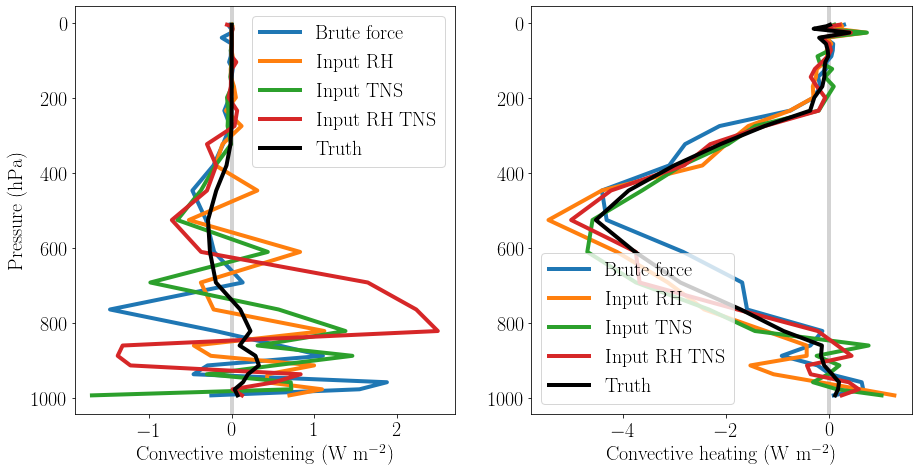

In [49]:
data = 'M4K_valid'

plt.figure(figsize=(15,7.5))

plt.subplot(1,2,1)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
#for iNN,NNs in enumerate(['CI02_RH.hdf5','CI01_RH_TNS.hdf5']):
    plt.plot(np.mean(diagno[NNs][data]['PHQ'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data]['PHQ'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend()
plt.xlabel('Convective moistening ($\mathrm{W\ m^{-2}}$)')
plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()
#plt.xlim((-20,20))

plt.subplot(1,2,2)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
#for iNN,NNs in enumerate(['CI02_RH.hdf5','CI01_RH_TNS.hdf5']):
    plt.plot(np.mean(diagno[NNs][data]['TPHYSTND'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data]['TPHYSTND'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend()
plt.xlabel('Convective heating ($\mathrm{W\ m^{-2}}$)')
plt.gca().invert_yaxis()
#plt.xlim((-9,9))

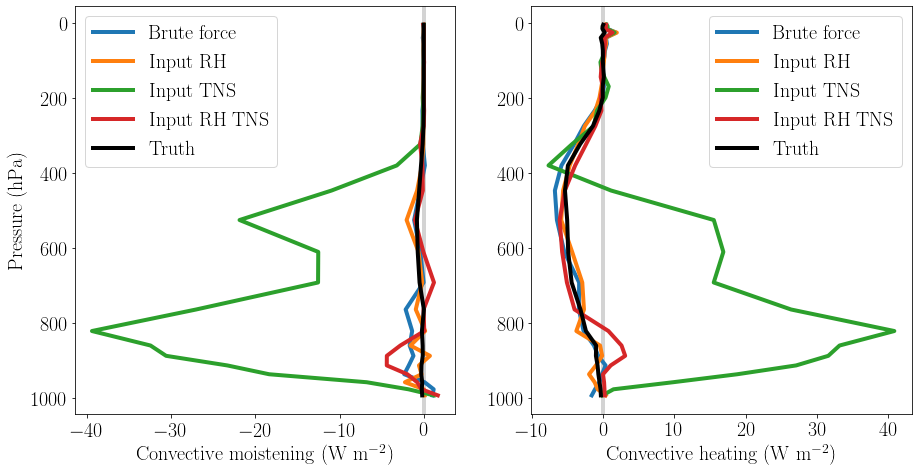

In [50]:
data = 'P4K_valid'

plt.figure(figsize=(15,7.5))

plt.subplot(1,2,1)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
#for iNN,NNs in enumerate(['CI02_RH.hdf5','CI01_RH_TNS.hdf5']):
    plt.plot(np.mean(diagno[NNs][data]['PHQ'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data]['PHQ'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend()
plt.xlabel('Convective moistening ($\mathrm{W\ m^{-2}}$)')
plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()
#plt.xlim((-20,20))

plt.subplot(1,2,2)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
#for iNN,NNs in enumerate(['CI02_RH.hdf5','CI01_RH_TNS.hdf5']):
    plt.plot(np.mean(diagno[NNs][data]['TPHYSTND'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data]['TPHYSTND'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend()
plt.xlabel('Convective heating ($\mathrm{W\ m^{-2}}$)')
plt.gca().invert_yaxis()
#plt.xlim((-9,9))

# Input Rescaling 2.2: Equivalent potential temperature minus near-surface

## Add code to pre-process equivalent potential temperature

Added to [https://github.com/tbeucler/CBRAIN-CAM/blob/master/cbrain/preprocessing/convert_dataset_20191113.py]:
```
elif var == 'EPTNS':
            da = compute_EPTNS(ds)
```

After debugging, the preprocessing code (in [https://github.com/tbeucler/CBRAIN-CAM/blob/master/cbrain/preprocessing/convert_dataset_20191113.py]) is:

TODO

The configuration file ```CI_EPT_M4K_NORM.yml``` is:

```
# Climate-invariant - Equivalent potential temperature (EPT) minus Near-surface EPT - Minus 4K - Norm
vars : [QBP, EPTNS, PS, SOLIN, SHFLX, LHFLX, PHQ, TPHYSTND, FSNT, FSNS, FLNT, FLNS]

in_dir : /project/meteo/w2w/A6/S.Rasp/SP-CAM/sp8fbp_minus4k
in_fns : sp8fbp_minus4k.cam2.h2.0001-01-0*-00000.nc

out_dir: /local/Tom.Beucler/SPCAM_PHYS/
out_fn: CI_EPTNS_M4K_NORM_train.nc

val_in_fns: sp8fbp_minus4k.cam2.h2.0001-01-0*-00000.nc
val_out_fn: CI_EPTNS_M4K_NORM_valid.nc

norm_fn: CI_EPTNS_M4K_NORM_norm.nc
```

## TODO 

# Input Rescaling 2.3: Absolute temperature lapse rate

## Add code to pre-process temperature

Added to [https://github.com/tbeucler/CBRAIN-CAM/blob/master/cbrain/preprocessing/convert_dataset_20191113.py]

```
elif var == 'LR':
            da = compute_LR(ds)
```

After debugging, the preprocessing code (in [https://github.com/tbeucler/CBRAIN-CAM/blob/master/cbrain/preprocessing/convert_dataset_20191113.py]) is:
```
def compute_LR(ds):
    
    C_P = 1.00464e3 # Specific heat capacity of air at constant pressure
    G = 9.80616 # Gravity constant
    
    def PI(PS,P0,hyai,hybi):    
        S = PS.shape
        return np.moveaxis(np.tile(P0,(31,S[1],S[2],1)),[0,1,2,3],[1,2,3,0]) *\
    np.moveaxis(np.tile(hyai,(S[1],S[2],1,1)),[0,1,2,3],[2,3,0,1]) + \
    np.moveaxis(np.tile(PS.values,(31,1,1,1)),0,1) * \
    np.moveaxis(np.tile(hybi,(S[1],S[2],1,1)),[0,1,2,3],[2,3,0,1])
    
    def rho(qv,T,PS,P0,hyam,hybm):
        eps = 0.622 # Ratio of molecular weight(H2O)/molecular weight(dry air)
        R_D = 287 # Specific gas constant of dry air in J/K/k

        r = qv/(qv**0-qv)
        Tv = T*(r**0+r/eps)/(r**0+r)

        S = Tv.shape
        p = np.moveaxis(np.tile(P0,(30,S[2],S[3],1)),[0,1,2,3],[1,2,3,0]) *\
        np.moveaxis(np.tile(hyam,(S[2],S[3],1,1)),[0,1,2,3],[2,3,0,1]) + \
        np.moveaxis(np.tile(PS.values,(30,1,1,1)),0,1) * \
        np.moveaxis(np.tile(hybm,(S[2],S[3],1,1)),[0,1,2,3],[2,3,0,1])

        return p/(R_D*Tv)
    
    PI_ds = PI(ds['PS'],ds['P0'],ds['hyai'],ds['hybi'])
    TI_ds = np.concatenate((compute_bp(ds,'TBP'),
                            np.expand_dims(ds['TS'][1:,:,:],axis=1)),axis=1)
    RHO_ds = rho(compute_bp(ds,'QBP'),compute_bp(ds,'TBP'),ds['PS'][1:,:,:],
                 ds['P0'][1:],ds['hyam'][1:,:],ds['hybm'][1:,:])
    
    return C_P*RHO_ds.values*(TI_ds[:,1:,:,:]-TI_ds[:,:-1,:,:])/\
(PI_ds[1:,1:,:,:]-PI_ds[1:,:-1,:,:])*\
ds['TAP'][1:,:,:,:]**0 # Multiplication by 1 to keep xarray attributes
# No need for it in custom tf layer
```

The configuration file ```CI_LR_M4K_NORM.yml``` is:

```
# Climate-invariant - Temperature lapse rate - Minus 4K - Norm
vars : [QBP, LR, PS, SOLIN, SHFLX, LHFLX, PHQ, TPHYSTND, FSNT, FSNS, FLNT, FLNS]

in_dir : /project/meteo/w2w/A6/S.Rasp/SP-CAM/sp8fbp_minus4k
in_fns : sp8fbp_minus4k.cam2.h2.0001-01-0*-00000.nc

out_dir: /local/Tom.Beucler/SPCAM_PHYS/
out_fn: CI_LR_M4K_NORM_train.nc

val_in_fns: sp8fbp_minus4k.cam2.h2.0001-01-0*-00000.nc
val_out_fn: CI_LR_M4K_NORM_valid.nc

norm_fn: CI_LR_M4K_NORM_norm.nc
```

In [35]:
%cd /filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM
!python preprocessing-11132019.py -c /home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/CI_LR_M4K_NORM.yml

/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/t

In [2]:
# Check the new normalization file
norm_LR = xr.open_dataset("/local/Tom.Beucler/SPCAM_PHYS/CI_LR_M4K_NORM_norm.nc",\
                    decode_times=False)

In [3]:
norm_LR['mean'][30:60] #mean LR

<xarray.DataArray 'mean' (var_names: 30)>
array([-0.127253, -0.368764,  0.493521, -0.115284, -0.204246, -0.253557,
       -0.138767,  0.020175,  0.127849,  0.189443,  0.193094,  0.193543,
        0.279324,  0.420166,  0.583519,  0.702779,  0.750621,  0.74906 ,
        0.66424 ,  0.606886,  0.534196,  0.478569,  0.503461,  0.631244,
        0.675722,  0.73535 ,  0.786999,  0.794242,  0.870876,  1.42162 ])
Coordinates:
  * var_names  (var_names) object 'LR' 'LR' 'LR' 'LR' ... 'LR' 'LR' 'LR' 'LR'

In [4]:
norm_LR['std'][30:60] #std LR

<xarray.DataArray 'std' (var_names: 30)>
array([0.118578, 0.129971, 0.139499, 0.143867, 0.214225, 0.298655, 0.214833,
       0.207688, 0.29555 , 0.363866, 0.42767 , 0.47339 , 0.470122, 0.425838,
       0.318752, 0.200064, 0.131948, 0.111462, 0.111904, 0.134072, 0.18751 ,
       0.233662, 0.181899, 0.200224, 0.18309 , 0.158922, 0.174992, 0.228773,
       0.368076, 0.937756])
Coordinates:
  * var_names  (var_names) object 'LR' 'LR' 'LR' 'LR' ... 'LR' 'LR' 'LR' 'LR'

In [5]:
norm_LR['max'][30:60] #mean LR

<xarray.DataArray 'max' (var_names: 30)>
array([0.227691, 0.060368, 0.884266, 0.332746, 0.286162, 0.239815, 0.348627,
       1.095352, 1.115462, 1.091084, 1.073307, 1.143235, 1.172966, 1.139964,
       1.140435, 1.162141, 1.122276, 1.079178, 0.983041, 0.949015, 0.92547 ,
       0.87516 , 0.864424, 1.101345, 1.192173, 1.33743 , 1.354931, 1.484112,
       2.046054, 7.992242])
Coordinates:
  * var_names  (var_names) object 'LR' 'LR' 'LR' 'LR' ... 'LR' 'LR' 'LR' 'LR'

In [6]:
norm_LR['min'][30:60] #mean LR

<xarray.DataArray 'min' (var_names: 30)>
array([-0.41571 , -0.795304, -0.158243, -0.489801, -1.058863, -1.414566,
       -1.908186, -1.210609, -0.599797, -0.612235, -1.23437 , -1.203561,
       -1.091678, -0.625609, -0.551385, -0.540704, -0.147833, -0.163115,
        0.025668, -0.325754, -0.581054, -1.180969, -1.298443, -2.183805,
       -2.260869, -2.643157, -3.297278, -5.068191, -7.506471, -2.986149])
Coordinates:
  * var_names  (var_names) object 'LR' 'LR' 'LR' 'LR' ... 'LR' 'LR' 'LR' 'LR'

## Tensorflow layer

In [71]:
# Moist thermo library adapted to tf
# Harcode P0=1e5 for now as it is not an input of the NN
def PI(PS,hyai,hybi):
    return np.float32(1.0e5)*hyai+PS[:,None]*hybi
    
def rho(qv,T,PS,hyam,hybm):
    eps = np.float32(0.622) # Ratio of molecular weight(H2O)/molecular weight(dry air)
    R_D = np.float32(287.0) # Specific gas constant of dry air in J/K/k

    qv = tf.cast(qv,tf.float32)
    T = tf.cast(T,tf.float32)
    
    r = qv/(qv**0-qv)
    Tv = T*(r**0+r/eps)/(r**0+r)

    S = Tv.shape
    p = np.float32(1.0e5)*hyam+PS[:,None]*hybm

    return p/(R_D*Tv)

In [72]:
class T2LR(Layer):
    def __init__(self, inp_subT, inp_divT, inp_subLR, inp_divLR, hyam, hybm, hyai, hybi, **kwargs):
        """
        From temperature to lapse_rate/dry_adiabatic_lapse_rate
        Call using ([input])
        Assumes
        prior: [QBP, 
        TBP, 
        PS, SOLIN, SHFLX, LHFLX]
        Returns
        post(erior): [QBP,
        LR, 
        PS, SOLIN, SHFLX, LHFLX]
        Arguments:
        inp_subT = Normalization based on input with temperature (subtraction constant)
        inp_divT = Normalization based on input with temperature (division constant)
        inp_subLR = Normalization based on input with lapse rate (subtraction constant)
        inp_divLR = Normalization based on input with lapse rate (division constant)
        hyam = Constant a for pressure based on mid-levels
        hybm = Constant b for pressure based on mid-levels
        hyai = Constant a for pressure based on interface levels
        hybi = Constant b for pressure based on interface levels
        """
        self.inp_subT, self.inp_divT, self.inp_subLR, self.inp_divLR, self.hyam, self.hybm, self.hyai, self.hybi = \
            np.array(inp_subT), np.array(inp_divT), np.array(inp_subLR), np.array(inp_divLR), \
        np.array(hyam), np.array(hybm), np.array(hyai), np.array(hybi)
        # Define variable indices here
        # Input
        self.QBP_idx = slice(0,30)
        self.TBP_idx = slice(30,60)
        self.PS_idx = 60
        self.SHFLX_idx = 62
        self.LHFLX_idx = 63

        super().__init__(**kwargs)

    def build(self, input_shape):
        super().build(input_shape)

    def get_config(self):
        config = {'inp_subT': list(self.inp_subT), 'inp_divT': list(self.inp_divT),
                  'inp_subLR': list(self.inp_subLR), 'inp_divLR': list(self.inp_divLR),
                  'hyam': list(self.hyam), 'hybm': list(self.hybm),
                  'hyai': list(self.hyai),'hybi': list(self.hybi)}
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
    def call(self, arrs):
        C_P = np.float32(1.00464e3) # Specific heat capacity of air at constant pressure
        
        prior = arrs
        
        Tprior = prior[:,self.TBP_idx]*self.inp_divT[self.TBP_idx]+self.inp_subT[self.TBP_idx]
        Qprior = prior[:,self.QBP_idx]*self.inp_divT[self.QBP_idx]+self.inp_subT[self.QBP_idx]
        PSprior = prior[:,self.PS_idx]*self.inp_divT[self.PS_idx]+self.inp_subT[self.PS_idx]
        
        PIprior = PI(PSprior,hyai,hybi)
        RHOprior = rho(Qprior,Tprior,PSprior,hyam,hybm)
        # Lacking surface temperature, so adding a dummy 0 to the lapse rate
        # By concatenating the temperature profile with its near-surface value
        TIprior = tf.concat([Tprior,tf.expand_dims(Tprior[:,-1],axis=1)],axis=1)

        LR = C_P*RHOprior*(TIprior[:,1:]-TIprior[:,:-1])/(PIprior[:,1:]-PIprior[:,:-1])
        LRprior = (LR-self.inp_subLR[self.TBP_idx])/self.inp_divLR[self.TBP_idx]
        
        post = tf.concat([prior[:,:30],tf.cast(LRprior,tf.float32),prior[:,60:]], axis=1)
        
        return post

    def compute_output_shape(self,input_shape):
        """Input shape + 1"""
        return (input_shape[0][0])

## Build generators

### Using specific humidity inputs

In [14]:
scale_dict = load_pickle('./nn_config/scale_dicts/009_Wm2_scaling.pkl')

in_vars = ['QBP','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']


TRAINFILE = 'CI_SP_M4K_train_shuffle.nc'
NORMFILE = 'CI_SP_M4K_NORM_norm.nc'
VALIDFILE = 'CI_SP_M4K_valid.nc'


train_gen = DataGenerator(
    data_fn = TRAINDIR+TRAINFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True
)

valid_gen = DataGenerator(
    data_fn = TRAINDIR+VALIDFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True
)

### Using LR inputs

In [15]:
in_vars = ['QBP','LR','PS', 'SOLIN', 'SHFLX', 'LHFLX']
out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']

In [18]:
TRAINFILE_LR = 'CI_LR_M4K_NORM_train_shuffle.nc'
NORMFILE_LR = 'CI_LR_M4K_NORM_norm.nc'
VALIDFILE_LR = 'CI_LR_M4K_NORM_valid.nc'

In [19]:
train_gen_LR = DataGenerator(
    data_fn = TRAINDIR+TRAINFILE_LR,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE_LR,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True
)

In [20]:
print(train_gen_LR[50][0].shape)
print(train_gen_LR[50][1].shape)
print(train_gen_LR[78][0].shape)
print(train_gen_LR[78][1].shape)

(1024, 64)
(1024, 64)
(1024, 64)
(1024, 64)


### Using RH inputs

In [21]:
scale_dict_RH = load_pickle('./nn_config/scale_dicts/009_Wm2_scaling.pkl')

scale_dict_RH['RH'] = 0.01*L_S/G, # Arbitrary 0.1 factor as specific humidity is generally below 2%

in_vars_RH = ['RH','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
out_vars_RH = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']

TRAINFILE_RH = 'CI_RH_M4K_NORM_train_shuffle.nc'
NORMFILE_RH = 'CI_RH_M4K_NORM_norm.nc'
VALIDFILE_RH = 'CI_RH_M4K_NORM_valid.nc'

train_gen_RH = DataGenerator(
    data_fn = TRAINDIR+TRAINFILE_RH,
    input_vars = in_vars_RH,
    output_vars = out_vars_RH,
    norm_fn = TRAINDIR+NORMFILE_RH,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict_RH,
    batch_size=1024,
    shuffle=True
)

In [22]:
print(train_gen_RH[50][0].shape)
print(train_gen_RH[50][1].shape)
print(train_gen_RH[78][0].shape)
print(train_gen_RH[78][1].shape)

(1024, 64)
(1024, 64)
(1024, 64)
(1024, 64)


## Model converting temperature to lapse rate as inputs

In [73]:
inp = Input(shape=(64,))
inpLR = T2LR(inp_subT=train_gen.input_transform.sub, 
              inp_divT=train_gen.input_transform.div, 
              inp_subLR=train_gen_LR.input_transform.sub, 
              inp_divLR=train_gen_LR.input_transform.div, 
              hyam=hyam, hybm=hybm, hyai=hyai, hybi=hybi)(inp)
densout = Dense(128, activation='linear')(inpLR)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (6):
    densout = Dense(128, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
out = Dense(64, activation='linear')(densout)
Input_LR = tf.keras.models.Model(inp, out)

In [74]:
Input_LR.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 64)]              0         
_________________________________________________________________
t2lr_17 (T2LR)               (None, 64)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 128)               8320      
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 128)               16512     
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 128)               1651

## Replace both T and q

In [75]:
inp2 = Input(shape=(64,))
inpRH = QV2RH(inp_subQ=train_gen.input_transform.sub, 
              inp_divQ=train_gen.input_transform.div, 
              inp_subRH=train_gen_RH.input_transform.sub, 
              inp_divRH=train_gen_RH.input_transform.div, 
              hyam=hyam, hybm=hybm)(inp2)
inpLR = T2LR(inp_subT=train_gen.input_transform.sub, 
              inp_divT=train_gen.input_transform.div, 
              inp_subLR=train_gen_LR.input_transform.sub, 
              inp_divLR=train_gen_LR.input_transform.div, 
              hyam=hyam, hybm=hybm, hyai=hyai, hybi=hybi)(inpRH)
densout = Dense(128, activation='linear')(inpLR)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (6):
    densout = Dense(128, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
out2 = Dense(64, activation='linear')(densout)
Input_RH_LR = tf.keras.models.Model(inp2, out2)

In [76]:
Input_RH_LR.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 64)]              0         
_________________________________________________________________
q_v2rh_1 (QV2RH)             (None, 64)                0         
_________________________________________________________________
t2lr_18 (T2LR)               (None, 64)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 128)               8320      
_________________________________________________________________
leaky_re_lu_28 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 128)               16512     
_________________________________________________________________
leaky_re_lu_29 (LeakyReLU)   (None, 128)               0   

## Compile and train both models

In [77]:
path_HDF5 = '/local/Tom.Beucler/SPCAM_PHYS/HDF5_DATA/'
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save_LR = ModelCheckpoint(path_HDF5+'CI01_LR.hdf5',save_best_only=True, monitor='val_loss', mode='min')
mcp_save_RH_LR = ModelCheckpoint(path_HDF5+'CI01_RH_LR.hdf5',save_best_only=True, monitor='val_loss', mode='min')

In [78]:
Input_LR.compile(tf.keras.optimizers.Adam(), loss=mse)
Input_RH_LR.compile(tf.keras.optimizers.Adam(), loss=mse)

In [ ]:
Nep = 10
Input_LR.fit_generator(train_gen, epochs=Nep, validation_data=valid_gen,\
              callbacks=[earlyStopping, mcp_save_LR])

Epoch 1/10
 8694/41376 [=====>........................] - ETA: 2:06 - loss: 510.5359

In [ ]:
Nep = 10
Input_RH_LR.fit_generator(train_gen, epochs=Nep, validation_data=valid_gen,\
              callbacks=[earlyStopping, mcp_save_LR_TNS])